In [1]:
import pandas as pd
import pickle
from scipy.stats import poisson

In [2]:
dict_table = pickle.load(open('data/dict_table','rb'))
df_historical_data = pd.read_csv('data/clean_fifa_worldcup_matches.csv')
df_fixture = pd.read_csv('data/clean_fifa_worldcup_fixture.csv')

# Calculate Team Strength

In [3]:
df_home = df_historical_data[['HomeTeam', 'HomeGoals', 'AwayGoals']]
df_away = df_historical_data[['AwayTeam', 'HomeGoals', 'AwayGoals']]

df_home = df_home.rename(columns={'HomeTeam':'Team', 'HomeGoals': 'GoalsScored', 'AwayGoals': 'GoalsConceded'})
df_away = df_away.rename(columns={'AwayTeam':'Team', 'HomeGoals': 'GoalsConceded', 'AwayGoals': 'GoalsScored'})

#pd.concat连接起来把列表或者行元素
df_team_strength = pd.concat([df_home, df_away], ignore_index=True).groupby(['Team']).mean()
df_team_strength.to_csv('data/TeamStrength.csv',index=True)


In [4]:
df_team_strength

,GoalsScored,GoalsConceded
Team,,
Algeria,1.000000,1.461538
Angola,0.333333,0.666667
Argentina,1.691358,1.148148
Australia,0.812500,1.937500
Austria,1.482759,1.620690
...,...,...
Uruguay,1.553571,1.321429
Wales,0.800000,0.800000
West Germany,2.112903,1.241935


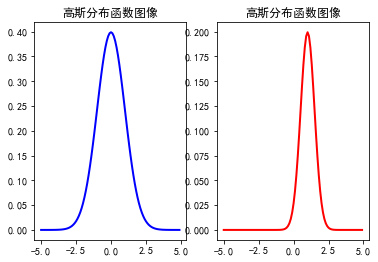

In [5]:
# plot Gaussian Function
# 注：正态分布也叫高斯分布
import matplotlib.pyplot as plt
import numpy as np
 
u1 = 0  # 第一个高斯分布的均值
sigma1 = 1  # 第一个高斯分布的标准差
 
u2 = 1  # 第二个高斯分布的均值
sigma2 = 2  # 第二个高斯分布的标准差
x = np.arange(-5, 5, 0.1)
# 表示第一个高斯分布函数
y1 = np.multiply(np.power(np.sqrt(2 * np.pi) * sigma1, -1), np.exp(-np.power(x - u1, 2) / 2 * sigma1 ** 2))
# 表示第二个高斯分布函数
y2 = np.multiply(np.power(np.sqrt(2 * np.pi) * sigma2, -1), np.exp(-np.power(x - u2, 2) / 2 * sigma2 ** 2))
 
plt.rcParams['font.sans-serif'] = ['SimHei']  # 解决pythonmatplotlib绘图无法显示中文的问题
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
 
plt.subplot(121)
plt.plot(x, y1, 'b-', linewidth=2)
plt.title("高斯分布函数图像")
 
plt.subplot(122)
plt.plot(x, y2, 'r-', linewidth=2)
plt.title('高斯分布函数图像')
plt.show()

In [6]:
import random
def lukyordie(miu,sigma):
    a=random.gauss(miu,sigma)
    return a

# Function predict_points

In [58]:
def predict_points(home, away):
    if home in df_team_strength.index and away in df_team_strength.index:
        # goals_scored * goals_conceded
        lamb_home = df_team_strength.at[home,'GoalsScored'] * df_team_strength.at[away,'GoalsConceded']
        lamb_away = df_team_strength.at[away,'GoalsScored'] * df_team_strength.at[home,'GoalsConceded']
        prob_home, prob_away, prob_draw = 0, 0, 0
        
        # luckordie much real, a little bit similar with performance disturbance of each team
        for x in range(0,11): #number of goals home team
            for y in range(0, 11): #number of goals away team
                p = poisson.pmf(x, lamb_home) * poisson.pmf(y, lamb_away)+lukyordie(0,0.005)
                if x == y:
                    prob_draw += p
                elif x > y:
                    prob_home += p
                else:
                    prob_away += p
        
        points_home = 3 * prob_home + prob_draw
        points_away = 3 * prob_away + prob_draw
        return (points_home, points_away)
    else:
        return (0, 0)

## Testing function

In [102]:
print(predict_points('Japan', 'Germany'))
print(predict_points('Argentina', 'Mexico'))
print(predict_points('Qatar (H)', 'Ecuador')) # Qatar vs Team X -> 0 points to both

(0.5056271926971796, 2.4671787348522205)
(2.4035284619998727, 0.5428924416980975)
(0, 0)


# Predicting World Cup

## Group stage

In [60]:
df_fixture_group_48 = df_fixture[:48].copy()
df_fixture_knockout = df_fixture[48:56].copy()
df_fixture_quarter = df_fixture[56:60].copy()
df_fixture_semi = df_fixture[60:62].copy()
df_fixture_final = df_fixture[62:].copy()

In [61]:
dict_table['Group H']

,Team,Pts
0,South Korea,66.81367701518893
1,Portugal,35.515473691781565
2,Uruguay,28.45719057911877
3,Ghana,27.01155829033276


In [62]:
for group in dict_table:
    teams_in_group = dict_table[group]['Team'].values
    df_fixture_group_6 = df_fixture_group_48[df_fixture_group_48['home'].isin(teams_in_group)]
    for index, row in df_fixture_group_6.iterrows():
        home, away = row['home'], row['away']
        points_home, points_away = predict_points(home, away)
        print("current group:>>>>", group)
        print('home and away:%s,%s'%(home,away))
        print("before frame:",dict_table[group])
        try:  
            dict_table[group].loc[dict_table[group]['Team'] == home, 'Pts'] += points_home
            dict_table[group].loc[dict_table[group]['Team'] == away, 'Pts'] += points_away
        except:
            a=dict_table[group].loc[dict_table[group]['Team'] == home, 'Pts']
            for x in a.str.split():
                aa= x[0].split('[')[0]
                print(aa)
            aa = float(aa) + points_home
            dict_table[group].loc[dict_table[group]['Team'] == home, 'Pts'] = str(aa)
            b = dict_table[group].loc[dict_table[group]['Team'] == away, 'Pts']
            for y in b.str.split():
                bb = y[0].split('[')[0]
            bb = float(bb) +points_away
            dict_table[group].loc[dict_table[group]['Team'] == away, 'Pts'] = str(bb)
        print("after frame:",dict_table[group])
            
            #print('a',a)
            #dict_table[group].loc[dict_table[group]['Team'] == home, 'Pts'] = a+ points_home
            #b = float(dict_table[group].loc[dict_table[group]['Team'] == away, 'Pts'].str.split("[")[0][0])
            #print('b',b)
            #dict_table[group].loc[dict_table[group]['Team'] == away, 'Pts'] = b+points_away

    dict_table[group] = dict_table[group].sort_values('Pts', ascending=False).reset_index()
    dict_table[group] = dict_table[group][['Team', 'Pts']]
    dict_table[group] = dict_table[group].round(0)

current group:>>>> Group A
home and away:Senegal,Netherlands
before frame:           Team                Pts
0      Senegal  8.986982980842066
1      Ecuador  35.99358909345266
2  Netherlands  16.52289928005662
3    Qatar (H)               0[b]
8.986982980842066
after frame:           Team                 Pts
0      Senegal   9.733691133068923
1      Ecuador   35.99358909345266
2  Netherlands  18.494850184266763
3    Qatar (H)                0[b]
current group:>>>> Group A
home and away:Netherlands,Ecuador
before frame:           Team                 Pts
0      Senegal   9.733691133068923
1      Ecuador   35.99358909345266
2  Netherlands  18.494850184266763
3    Qatar (H)                0[b]
18.494850184266763
after frame:           Team                 Pts
0      Senegal   9.733691133068923
1      Ecuador  36.722338582333904
2  Netherlands   20.51073548184047
3    Qatar (H)                0[b]
current group:>>>> Group A
home and away:Ecuador,Senegal
before frame:           Team       

current group:>>>> Group D
home and away:Australia,Denmark
before frame:         Team                 Pts
0     France   35.24319140459028
1    Tunisia   27.57632816178351
2  Australia  16.516421270492945
3    Denmark  17.215548037145663
16.516421270492945
after frame:         Team                 Pts
0     France   35.24319140459028
1    Tunisia   27.57632816178351
2  Australia  17.021999893485688
3    Denmark   19.63105993942632
current group:>>>> Group D
home and away:Tunisia,France
before frame:         Team                 Pts
0     France   35.24319140459028
1    Tunisia   27.57632816178351
2  Australia  17.021999893485688
3    Denmark   19.63105993942632
27.57632816178351
after frame:         Team                 Pts
0     France  37.907683179322895
1    Tunisia  28.191759482120965
2  Australia  17.021999893485688
3    Denmark   19.63105993942632
current group:>>>> Group E
home and away:Germany,Japan
before frame:          Team   Pts
0       Japan  47.0
1       Spain  27.0
2    

3        Ghana  29.760984207497224
current group:>>>> Group H
home and away:Portugal,Uruguay
before frame:           Team                 Pts
0  South Korea    68.2382811373678
1     Portugal   37.31724547993409
2      Uruguay  30.971388037954636
3        Ghana  29.760984207497224
37.31724547993409
after frame:           Team                 Pts
0  South Korea    68.2382811373678
1     Portugal   38.99866763561648
2      Uruguay  32.166793502297274
3        Ghana  29.760984207497224
current group:>>>> Group H
home and away:Ghana,Uruguay
before frame:           Team                 Pts
0  South Korea    68.2382811373678
1     Portugal   38.99866763561648
2      Uruguay  32.166793502297274
3        Ghana  29.760984207497224
29.760984207497224
after frame:           Team                 Pts
0  South Korea    68.2382811373678
1     Portugal   38.99866763561648
2      Uruguay  33.888379681496396
3        Ghana  30.880273758025854
current group:>>>> Group H
home and away:South Korea,Portugal

In [63]:
dict_table['Group B']

,Team,Pts
0,United States,20.987574662174858
1,Wales,17.784104572647514
2,England,15.301978377786726
3,Iran,-16.360205922157892


## Knock out

In [64]:
df_fixture_knockout

,home,score,away,year
48,Winners Group A,Match 49,Runners-up Group B,2022
49,Winners Group C,Match 50,Runners-up Group D,2022
50,Winners Group D,Match 52,Runners-up Group C,2022
51,Winners Group B,Match 51,Runners-up Group A,2022
52,Winners Group E,Match 53,Runners-up Group F,2022
53,Winners Group G,Match 54,Runners-up Group H,2022
54,Winners Group F,Match 55,Runners-up Group E,2022
55,Winners Group H,Match 56,Runners-up Group G,2022


In [65]:
for group in dict_table:
    group_winner = dict_table[group].loc[0, 'Team']
    runners_up = dict_table[group].loc[1, 'Team']
    df_fixture_knockout.replace({f'Winners {group}':group_winner,
                                 f'Runners-up {group}':runners_up}, inplace=True)

df_fixture_knockout['winner'] = '?'
df_fixture_knockout

,home,score,away,year,winner
48,Ecuador,Match 49,Wales,2022,?
49,Argentina,Match 50,Tunisia,2022,?
50,France,Match 52,Poland,2022,?
51,United States,Match 51,Netherlands,2022,?
52,Japan,Match 53,Croatia,2022,?
53,Switzerland,Match 54,Portugal,2022,?
54,Morocco,Match 55,Spain,2022,?
55,South Korea,Match 56,Cameroon,2022,?


In [66]:
def get_winner(df_fixture_updated):
    for index, row in df_fixture_updated.iterrows():
        home, away = row['home'], row['away']
        points_home, points_away = predict_points(home, away)
        if points_home > points_away:
            winner = home
        else:
            winner = away
        df_fixture_updated.loc[index, 'winner'] = winner
    return df_fixture_updated

In [67]:
get_winner(df_fixture_knockout)

,home,score,away,year,winner
48,Ecuador,Match 49,Wales,2022,Wales
49,Argentina,Match 50,Tunisia,2022,Argentina
50,France,Match 52,Poland,2022,France
51,United States,Match 51,Netherlands,2022,Netherlands
52,Japan,Match 53,Croatia,2022,Croatia
53,Switzerland,Match 54,Portugal,2022,Portugal
54,Morocco,Match 55,Spain,2022,Spain
55,South Korea,Match 56,Cameroon,2022,South Korea


## Quarter Final

In [68]:
def update_table(df_fixture_round_1, df_fixture_round_2):
    for index, row in df_fixture_round_1.iterrows():
        winner = df_fixture_round_1.loc[index, 'winner']
        match = df_fixture_round_1.loc[index, 'score']
        df_fixture_round_2.replace({f'Winners {match}':winner}, inplace=True)
    df_fixture_round_2['winner'] = '?'
    return df_fixture_round_2

In [69]:
update_table(df_fixture_knockout, df_fixture_quarter)

,home,score,away,year,winner
56,Croatia,Match 58,Portugal,2022,?
57,Wales,Match 57,Argentina,2022,?
58,Spain,Match 60,South Korea,2022,?
59,Netherlands,Match 59,France,2022,?


In [70]:
get_winner(df_fixture_quarter)

,home,score,away,year,winner
56,Croatia,Match 58,Portugal,2022,Portugal
57,Wales,Match 57,Argentina,2022,Argentina
58,Spain,Match 60,South Korea,2022,Spain
59,Netherlands,Match 59,France,2022,Netherlands


## Semifinal

In [71]:
update_table(df_fixture_quarter, df_fixture_semi)

,home,score,away,year,winner
60,Argentina,Match 61,Portugal,2022,?
61,Netherlands,Match 62,Spain,2022,?


In [72]:
get_winner(df_fixture_semi)

,home,score,away,year,winner
60,Argentina,Match 61,Portugal,2022,Argentina
61,Netherlands,Match 62,Spain,2022,Netherlands


## Final

In [73]:
update_table(df_fixture_semi, df_fixture_final)

,home,score,away,year,winner
62,Losers Match 61,Match 63,Losers Match 62,2022,?
63,Argentina,Match 64,Netherlands,2022,?


In [74]:
get_winner(df_fixture_final)

,home,score,away,year,winner
62,Losers Match 61,Match 63,Losers Match 62,2022,Losers Match 62
63,Argentina,Match 64,Netherlands,2022,Netherlands
